# Import relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import joblib
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
dataset = pd.read_json(r'/content/drive/MyDrive/Datasets/News Category/News_Category_Dataset_v2.json', lines=True)

In [ ]:
dataset.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
dataset.loc[100, ['category', 'headline', 'short_description']].values

array(['POLITICS',
       'The Koch Network Is Going After One Of Trump’s Favorite Congressmen',
       'The billionaire Koch brothers’ political network wants to show it will punish Republicans who don’t support its agenda.'],
      dtype=object)

check data distribution based on category

In [ ]:
pd.DataFrame(dataset.groupby(['category']).size().sort_values(ascending=False), columns=['total news'])

,total news
category,
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226


# Data preprocessing

take top 4 categories

In [ ]:
dataset_small = dataset[dataset['category'].isin(['WELLNESS', 'POLITICS', 'ENTERTAINMENT', 'TRAVEL'])].loc[:, ['category', 'headline', 'short_description']].copy()

dataset_small.head()

,category,headline,short_description
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,"""It is not right to equate horrific incidents ..."


combine headline with short description

In [ ]:
headline_desc = dataset_small['headline'].values + ' ' + dataset_small['short_description'].values

In [ ]:
headline_desc[0]

"Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song."

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def text_preprocessing(text):
    # full text level
    # remove numbers
    no_num_text = re.sub(r'\d+', '', text)
    # lower case conversion
    lowercase_text = no_num_text.lower()

    # word level
    # tokenization
    tokens = nltk.tokenize.word_tokenize(lowercase_text)
    # remove stopwords
    no_stopwords_text = [word for word in tokens if not word in stopwords]
    # remove puncts    
    no_punct_text = [word for word in no_stopwords_text if word.isalpha()]
    # stemming    
    stemmed_text = [stemmer.stem(word) for word in no_punct_text]
    
    return ' '.join(stemmed_text)

In [ ]:
X = np.array([text_preprocessing(text) for text in headline_desc])

In [ ]:
X.shape

(76511,)

In [ ]:
y_full = dataset_small['category'].values

In [ ]:
y_full.shape

(76511,)

convert features to tf-idf format

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(X)

In [ ]:
X_tfidf.shape

(76511, 1000)

train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_full, test_size=0.3)

# SVM model

## Training

In [ ]:
svm_model = SVC(kernel='poly', degree=3, coef0=1, C=5)

In [ ]:
svm_training_start = time.time()
svm_model.fit(X_train, y_train)
svm_training_end = time.time()

In [ ]:
print('svm training time : ', svm_training_end - svm_training_start, 's')

svm training time :  673.177906036377 s


## Evaluate

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.865600766750893

In [ ]:
print(metrics.classification_report(y_test, y_pred))

               precision    recall  f1-score   support

ENTERTAINMENT       0.79      0.82      0.80      4769
     POLITICS       0.91      0.91      0.91      9804
       TRAVEL       0.85      0.78      0.82      2995
     WELLNESS       0.86      0.88      0.87      5386

     accuracy                           0.87     22954
    macro avg       0.85      0.85      0.85     22954
 weighted avg       0.87      0.87      0.87     22954



## Save model

In [ ]:
joblib.dump(svm_model, 'svm-model.sav')

['svm-model.sav']

## Predict

In [ ]:
title = 'Why Meditation Can Improve Your productivity'
short_description = 'Meditation is one such wellness practice that not only offers immense spiritual benefits, but is incredibly helpful for maintaining physical and emotional health as well'

In [ ]:
def svm_predict(title: str, short_desc: str) -> str:
    # combine title and short desc
    title_desc = title + ' ' + short_description
    # preprocessing pipeline
    text_processed = text_preprocessing(title_desc)
    # convert to tf-idf
    text_tfidf = tfidf.transform([text_processed])

    return svm_model.predict(text_tfidf)[0]

In [ ]:
print('Prediction : ', svm_predict(title, short_description))

Prediction :  WELLNESS


# Neural Networks

In [ ]:
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

## Preprocessing

convert labels into one hot format

In [ ]:
y_full = OneHotEncoder(sparse=False).fit_transform(dataset_small['category'].values.reshape(-1,1))

tensorflow can't process sparse matrix, so need to convert to np array 

In [ ]:
X_tfidf_array = X_tfidf.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_array, y_full, test_size=0.3)

## Neural Nets Model

input_dim = tfidf vector dimension

In [ ]:
nn_model = keras.models.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_dim=1000),
    keras.layers.Dense(units=500, activation='relu'),
    keras.layers.Dense(units=200, activation='relu'),
    keras.layers.Dense(units=4, activation='softmax')
])

opt = keras.optimizers.SGD(learning_rate=0.1)

nn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 200)               100200    
                                                                 
 dense_3 (Dense)             (None, 4)                 804       
                                                                 
Total params: 1,602,504
Trainable params: 1,602,504
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
nn_training_start = time.time()
nn_traning_history = nn_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
nn_training_end = time.time()

Epoch 1/20
1674/1674 [==============================] - 11s 6ms/step - loss: 0.6815 - accuracy: 0.7308 - val_loss: 0.4190 - val_accuracy: 0.8511
Epoch 2/20
1674/1674 [==============================] - 10s 6ms/step - loss: 0.4129 - accuracy: 0.8540 - val_loss: 0.3967 - val_accuracy: 0.8580
Epoch 3/20
1674/1674 [==============================] - 9s 6ms/step - loss: 0.3760 - accuracy: 0.8666 - val_loss: 0.3988 - val_accuracy: 0.8561
Epoch 4/20
1674/1674 [==============================] - 9s 6ms/step - loss: 0.3564 - accuracy: 0.8737 - val_loss: 0.3890 - val_accuracy: 0.8619
Epoch 5/20
1674/1674 [==============================] - 9s 6ms/step - loss: 0.3370 - accuracy: 0.8802 - val_loss: 0.4481 - val_accuracy: 0.8395
Epoch 6/20
1674/1674 [==============================] - 10s 6ms/step - loss: 0.3147 - accuracy: 0.8877 - val_loss: 0.4278 - val_accuracy: 0.8531
Epoch 7/20
1674/1674 [==============================] - 9s 6ms/step - loss: 0.2938 - accuracy: 0.8953 - val_loss: 0.4373 - val_accura

In [ ]:
print('neural networks training time : ', nn_training_end - nn_training_start, 's')

neural networks training time :  192.48960518836975 s


(0.0, 1.0)

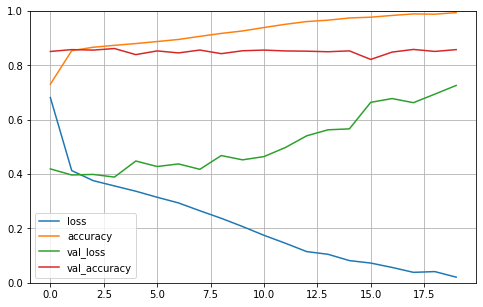

In [ ]:
pd.DataFrame(nn_traning_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

## Evaluation

In [ ]:
nn_model.evaluate(X_test, y_test)

718/718 [==============================] - 3s 4ms/step - loss: 0.7261 - accuracy: 0.8579


[0.7261236906051636, 0.8579332828521729]

## Prediction

In [ ]:
# title = 'Why Meditation Can Improve Your productivity'
# short_description = 'Meditation is one such wellness practice that not only offers immense spiritual benefits, but is incredibly helpful for maintaining physical and emotional health as well'

title = 'the new batman trailer release today'
short_description = 'the trailer introduce new characters such as catwoman, penguin and riddler'

In [ ]:
def nn_predict(title: str, short_description: str):
    labels = np.unique(dataset_small['category'].values)

    # combine title and short desc
    title_desc = title + ' ' + short_description
    # preprocessing pipeline
    text_processed = text_preprocessing(title_desc)
    # convert to tf-idf
    text_tfidf = tfidf.transform([text_processed])

    predicted_index = np.argmax(nn_model.predict(text_tfidf.toarray()))
    
    return labels[predicted_index]

In [ ]:
print('Prediction : ', nn_predict(title, short_description))

Prediction :  ENTERTAINMENT
